# Assignment 1
# Matthew Wirasakti
## Problem 1

In [319]:
from math import *
from decimal import Decimal

def p_root(value, root):
    root_value = 1 / float(root)
    return round (Decimal(value) ** Decimal(root_value), 6)

# distance calculation
def calculate_distance(row1,row2,distance_func=2):
    row1,row2=row1[:-1],row2[:-1]# remove lables, i.e., last index
    return float(p_root(sum(pow(abs(a-b), distance_func) for a, b in zip(row1, row2)), distance_func))

In [320]:
dataset = [
    [2.7810836,2.550537003,0],[1.465489372,2.362125076,0],[3.396561688,4.400293529,0],
    [1.38807019,1.850220317,0],[3.06407232,3.005305973,0],[7.627531214,2.759262235,1],
    [5.332441248,2.088626775,1],[6.922596716,1.77106367,1],[8.675418651,-0.242068655,1],
    [7.673756466,3.508563011,1]
]

# compute distance from data point at index 0
row0 = dataset[0]

distances = [calculate_distance(row0, row, 4) for row in dataset]
print(distances)

[0.0, 1.315733, 1.855399, 1.414746, 0.470933, 4.846452, 2.552043, 4.142812, 5.967218, 4.89447]


In [321]:
def get_neighbors(train, test_row, num_neighbors=3, distance_func=2):
    # compute distances
    distances = [(train_row, calculate_distance(test_row, train_row, distance_func)) for train_row in train]
    # sort
    distances.sort(key=lambda tup: tup[1])
    # get top-k neighbors
    neighbors = [distances[i][0]for i in range(num_neighbors)]
    
    return neighbors

In [322]:
# test get_get_neighbors function with top-3 neighbors
neighbors = get_neighbors(dataset, row0, distance_func=3)
print(neighbors)

[[2.7810836, 2.550537003, 0], [3.06407232, 3.005305973, 0], [1.465489372, 2.362125076, 0]]


In [323]:
def predict_classification(train, test_row, num_neighbors=3, distance_func=2):
    neighbors = get_neighbors(train, test_row, num_neighbors, distance_func)
    output_values = [row[-1] for row in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    return prediction

In [324]:
# test prediction function
prediction = predict_classification(dataset, row0)
print('Expected %d, Got %d.' %(dataset[0][-1], prediction))

Expected 0, Got 0.


In [325]:
# imports
from random import seed
from random import randrange
from csv import reader

In [326]:
# Load a CSV file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

In [327]:
# string to float
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

In [328]:
# string to integer
def str_column_to_int(dataset, column):
    unique = set([row[column] for row in dataset])
    lookup = {value: i for i, value in enumerate(unique)}
    
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup

In [329]:
# min and max values for each column
def dataset_minmax(dataset):
    minmax = list()
    for i in range(len(dataset[0])):
        col_values = [row[i] for row in dataset]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    return minmax

In [330]:
# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

In [331]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for _ in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [332]:
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

def precision_metric(actual, predicted):
    classes = list(set(actual))
    totPredictions = {
        i: 0 for i in classes
    }
    correctPred = {
        i: 0 for i in classes
    }
    
    for i in range(len(actual)):
        totPredictions[predicted[i]] += 1
        if (predicted[i] == actual[i]):
            correctPred[predicted[i]] += 1
            
    return [((correctPred[i] / totPredictions[i]) * 100.0) for i in totPredictions]

def recall_metric(actual, predicted):
    classes = list(set(actual))
    totActuals = {
        i: 0 for i in classes
    }
    correctPred = {
        i: 0 for i in classes
    }
    
    for i in range(len(actual)):
        totActuals[actual[i]] += 1
        if (predicted[i] == actual[i]):
            correctPred[predicted[i]] += 1
            
    return [((correctPred[i] / totActuals[i]) * 100.0) for i in totActuals]

def f1_metric(precision, recall):
    return [((2 * recall[i] * precision[i]) / (recall[i] + precision[i])) for i in range(len(precision))]

In [333]:
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    precisionScores = list()
    recallScores = list()
    f1Scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        precision = precision_metric(actual, predicted)
        recall = recall_metric(actual, predicted)
        f1Scores.append(f1_metric(precision, recall))
        scores.append(accuracy)
        precisionScores.append(precision)
        recallScores.append(recall)
        
    print('Precision Scores: %s' % precisionScores)
    print('Recall Scores: %s' % recallScores)
    print('F1 Scores: %s' % f1Scores)
    return scores

In [334]:
# kNN Algorithm
def k_nearest_neighbors(train, test, num_neighbors = 3, distance_func = 2):
    predictions = list()
    for row in test:
        output = predict_classification(train, row, num_neighbors, distance_func)
        predictions.append(output)
    return(predictions)

In [335]:
#Test the kNN on the Iris Flowers dataset
seed(1)
filename = 'iris.csv'
datasetIris = load_csv(filename)

for i in range(len(datasetIris[0])-1):
    str_column_to_float(datasetIris, i)

# convert class column to integers
str_column_to_int(datasetIris, len(datasetIris[0])-1)

# evaluate algorithm
n_folds = 5
num_neighbors = 5
distance_func = 2
scores = evaluate_algorithm(datasetIris, k_nearest_neighbors, n_folds, num_neighbors, distance_func)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float (len(scores))))

Precision Scores: [[91.66666666666666, 100.0, 100.0], [90.0, 100.0, 100.0], [100.0, 100.0, 100.0], [81.81818181818183, 88.88888888888889, 100.0], [100.0, 100.0, 100.0]]
Recall Scores: [[100.0, 87.5, 100.0], [100.0, 90.9090909090909, 100.0], [100.0, 100.0, 100.0], [90.0, 80.0, 100.0], [100.0, 100.0, 100.0]]
F1 Scores: [[95.65217391304347, 93.33333333333333, 100.0], [94.73684210526316, 95.23809523809523, 100.0], [100.0, 100.0, 100.0], [85.71428571428574, 84.21052631578948, 100.0], [100.0, 100.0, 100.0]]
Scores: [96.66666666666667, 96.66666666666667, 100.0, 90.0, 100.0]
Mean Accuracy: 96.667%


## Problem 2.1 and Problem 3 Metrics
(values in Problem 4)

In [336]:
#kNN on 1000+ dimension dataset
import random
seed(1)
dataset1000 = list()
sample = list()
for _ in range(1000):
    sample = [random.random() for _ in range(1000)]
    r = random.randint(0, 1)
    sample.append(r)
    dataset1000.append(sample)

# evaluate algorithm
n_folds = 5
num_neighbors = 5
distance_func = 2
# scores = evaluate_algorithm(dataset1000, k_nearest_neighbors, n_folds, num_neighbors, distance_func)
# print('Scores: %s' % scores)
# print('Mean Accuracy: %.3f%%' % (sum(scores)/float (len(scores))))

## Problem 2.2 and Problem 3 Metrics
(values in Problem 4)

In [337]:
#kNN on 100+ dimension dataset
import random
seed(1)
dataset100 = list()
sample = list()
for _ in range(150):
    sample = [random.random() for _ in range(100)]
    r = random.randint(0, 1)
    sample.append(r)
    dataset100.append(sample)

# evaluate algorithm
n_folds = 5
num_neighbors = 5
distance_func = 2
# scores = evaluate_algorithm(dataset100, k_nearest_neighbors, n_folds, num_neighbors, distance_func)
# print('Scores: %s' % scores)
# print('Mean Accuracy: %.3f%%' % (sum(scores)/float (len(scores))))

## Problem 2.3 and Problem 3 Metrics
(values in Problem 4)

In [338]:
# #kNN on bag of words dataset
import random
seed(1)
datasetBag = list()
sample = list()
goodCount = 0
badCount = 0
for _ in range (1000):
    sample = [random.randint(0, 1) for _ in range(10)]
    datasetBag.append(sample)

for i in range(len(datasetBag)):
    vocab = datasetBag[i]
    if (vocab[2] == 1 & vocab[4] == 1 & vocab[8] == 1):
        vocab.append(1)
#         goodCount += 1
    else:
        vocab.append(0)
#         badCount += 1
# print(goodCount)
# print(badCount)

# evaluate algorithm
n_folds = 5
num_neighbors = 5
distance_func = 2
# scores = evaluate_algorithm(datasetBag, k_nearest_neighbors, n_folds, num_neighbors, distance_func)
# print('Scores: %s' % scores)
# print('Mean Accuracy: %.3f%%' % (sum(scores)/float (len(scores))))

## Problem 4

In [369]:
print("Iris Dataset")
for num_neighbors in range(1, 11):
    n_folds = 5
    distance_func = 2
    print("k = ", num_neighbors)
    scores = evaluate_algorithm(datasetIris, k_nearest_neighbors, n_folds, num_neighbors, distance_func)
    print('Scores: %s' % scores)
    print('Mean Accuracy: %.3f%%' % (sum(scores)/float (len(scores))))
    print()

# 1000 not seen in output because it was already completed but takes to long to process a second time
print("1000 Dimension Dataset")
for num_neighbors in range(1, 11):
    n_folds = 5
    distance_func = 2
    print("k = ", num_neighbors)
    scores = evaluate_algorithm(dataset1000, k_nearest_neighbors, n_folds, num_neighbors, distance_func)
    print('Scores: %s' % scores)
    print('Mean Accuracy: %.3f%%' % (sum(scores)/float (len(scores))))
    print()

print("100 Dimension Dataset")
for num_neighbors in range(1, 6):
    n_folds = 5
    distance_func = 2
    print("k = ", num_neighbors)
    scores = evaluate_algorithm(dataset100, k_nearest_neighbors, n_folds, num_neighbors, distance_func)
    print('Scores: %s' % scores)
    print('Mean Accuracy: %.3f%%' % (sum(scores)/float (len(scores))))
    print()

print("Bag of Words Dataset")
for num_neighbors in range(1, 11):
    n_folds = 5
    distance_func = 2
    print("k = ", num_neighbors)
    scores = evaluate_algorithm(datasetBag, k_nearest_neighbors, n_folds, num_neighbors, distance_func)
    print('Scores: %s' % scores)
    print('Mean Accuracy: %.3f%%' % (sum(scores)/float (len(scores))))
    print()

Iris Dataset
k =  1
Precision Scores: [[91.66666666666666, 100.0, 100.0], [100.0, 100.0, 100.0], [90.9090909090909, 62.5, 100.0], [87.5, 87.5, 100.0], [100.0, 100.0, 100.0]]
Recall Scores: [[100.0, 92.3076923076923, 100.0], [100.0, 100.0, 100.0], [76.92307692307693, 83.33333333333334, 100.0], [87.5, 87.5, 100.0], [100.0, 100.0, 100.0]]
F1 Scores: [[95.65217391304347, 95.99999999999999, 100.0], [100.0, 100.0, 100.0], [83.33333333333334, 71.42857142857143, 100.0], [87.5, 87.5, 100.0], [100.0, 100.0, 100.0]]
Scores: [96.66666666666667, 100.0, 86.66666666666667, 93.33333333333333, 100.0]
Mean Accuracy: 95.333%

k =  2
Precision Scores: [[100.0, 100.0, 100.0], [87.5, 71.42857142857143, 100.0], [90.0, 100.0, 100.0], [100.0, 90.9090909090909, 100.0], [78.57142857142857, 100.0, 100.0]]
Recall Scores: [[100.0, 100.0, 100.0], [77.77777777777779, 83.33333333333334, 100.0], [100.0, 91.66666666666666, 100.0], [90.9090909090909, 100.0, 100.0], [100.0, 70.0, 100.0]]
F1 Scores: [[100.0, 100.0, 100.0],

Precision Scores: [[50.0, 75.0], [45.45454545454545, 75.0], [52.38095238095239, 33.33333333333333], [55.00000000000001, 30.0], [63.1578947368421, 63.63636363636363]]
Recall Scores: [[84.61538461538461, 35.294117647058826], [83.33333333333334, 33.33333333333333], [64.70588235294117, 23.076923076923077], [61.111111111111114, 25.0], [75.0, 50.0]]
F1 Scores: [[62.857142857142854, 48.00000000000001], [58.823529411764696, 46.153846153846146], [57.89473684210526, 27.272727272727266], [57.894736842105274, 27.272727272727273], [68.57142857142857, 56.0]]
Scores: [56.666666666666664, 53.333333333333336, 46.666666666666664, 46.666666666666664, 63.33333333333333]
Mean Accuracy: 53.333%

k =  5
Precision Scores: [[57.14285714285714, 66.66666666666666], [46.666666666666664, 60.0], [41.17647058823529, 61.53846153846154], [75.0, 55.55555555555556], [71.42857142857143, 43.75]]
Recall Scores: [[80.0, 40.0], [53.84615384615385, 52.94117647058824], [58.333333333333336, 44.44444444444444], [52.9411764705882

For the Iris dataset, k = 6 provided the best results

For the dataset with 1000 dimensions, k = 2 provided the best results with high accuracy and highest F1 Scores

For the dataset with 100 dimensions, k = 5 provided the best results

For the dataset with bag of words, k = 5 provided the best results

## Problem 5

In [370]:
print("Iris Dataset - Manhattan Distance")
n_folds = 5
num_neighbors = 5
distance_func = 1
scores = evaluate_algorithm(datasetIris, k_nearest_neighbors, n_folds, num_neighbors, distance_func)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float (len(scores))))
print()

print("Iris Dataset - Euclidean Distance")
n_folds = 5
num_neighbors = 5
distance_func = 2
scores = evaluate_algorithm(datasetIris, k_nearest_neighbors, n_folds, num_neighbors, distance_func)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float (len(scores))))
print()

print("1000 Dimension Dataset - Manhattan Distance")
n_folds = 5
num_neighbors = 5
distance_func = 1
scores = evaluate_algorithm(dataset1000, k_nearest_neighbors, n_folds, num_neighbors, distance_func)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float (len(scores))))
print()

print("1000 Dimension Dataset - Manhattan Distance")
n_folds = 5
num_neighbors = 5
distance_func = 2
scores = evaluate_algorithm(dataset1000, k_nearest_neighbors, n_folds, num_neighbors, distance_func)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float (len(scores))))
print()

print("100 Dimension Dataset - Manhattan Distance")
n_folds = 5
num_neighbors = 5
distance_func = 1
scores = evaluate_algorithm(dataset100, k_nearest_neighbors, n_folds, num_neighbors, distance_func)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float (len(scores))))
print()

print("100 Dimension Dataset - Euclidean Distance")
n_folds = 5
num_neighbors = 5
distance_func = 2
scores = evaluate_algorithm(dataset100, k_nearest_neighbors, n_folds, num_neighbors, distance_func)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float (len(scores))))
print()

print("Bag of Words Dataset - Manhattan Distance")
n_folds = 5
num_neighbors = 5
distance_func = 1
scores = evaluate_algorithm(datasetBag, k_nearest_neighbors, n_folds, num_neighbors, distance_func)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float (len(scores))))
print()

print("Bag of Words Dataset - Euclidean Distance")
n_folds = 5
num_neighbors = 5
distance_func = 2
scores = evaluate_algorithm(datasetBag, k_nearest_neighbors, n_folds, num_neighbors, distance_func)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float (len(scores))))
print()

Iris Dataset - Manhattan Distance
Precision Scores: [[77.77777777777779, 83.33333333333334, 100.0], [90.9090909090909, 100.0, 100.0], [100.0, 93.75, 100.0], [91.66666666666666, 100.0, 100.0], [100.0, 90.0, 100.0]]
Recall Scores: [[77.77777777777779, 83.33333333333334, 100.0], [100.0, 87.5, 100.0], [87.5, 100.0, 100.0], [100.0, 83.33333333333334, 100.0], [91.66666666666666, 100.0, 100.0]]
F1 Scores: [[77.77777777777779, 83.33333333333334, 100.0], [95.23809523809523, 93.33333333333333, 100.0], [93.33333333333333, 96.7741935483871, 100.0], [95.65217391304347, 90.9090909090909, 100.0], [95.65217391304347, 94.73684210526316, 100.0]]
Scores: [86.66666666666667, 96.66666666666667, 96.66666666666667, 96.66666666666667, 96.66666666666667]
Mean Accuracy: 94.667%

Iris Dataset - Euclidean Distance
Precision Scores: [[100.0, 100.0, 100.0], [100.0, 91.66666666666666, 100.0], [88.88888888888889, 100.0, 100.0], [87.5, 100.0, 100.0], [84.61538461538461, 100.0, 100.0]]
Recall Scores: [[100.0, 100.0, 10

Both Euclidean and Manhattan worked well on the datasets, but Manhattan worked for more of the datasets than Euclidean

## Problem 6
1. Runtime increases as dimensionality increases
2. The F1 score and accuracy decrease as dimensionality increases

## Problem 7

In [371]:
import random
seed(1)
datasetMeans = list()
sample = list()
for _ in range(10):
    sample = [random.random() for _ in range(2)]
    datasetMeans.append(sample)
print(datasetMeans)

[[0.13436424411240122, 0.8474337369372327], [0.763774618976614, 0.2550690257394217], [0.49543508709194095, 0.4494910647887381], [0.651592972722763, 0.7887233511355132], [0.0938595867742349, 0.02834747652200631], [0.8357651039198697, 0.43276706790505337], [0.762280082457942, 0.0021060533511106927], [0.4453871940548014, 0.7215400323407826], [0.22876222127045265, 0.9452706955539223], [0.9014274576114836, 0.030589983033553536]]


In [388]:
centroids = list()
centroids = k_means(datasetMeans, 3, 3)
# print(centroids)

[[0.13436424411240122, 0.8474337369372327], [0.763774618976614, 0.2550690257394217], [0.49543508709194095, 0.4494910647887381]]

[[0.24544949526240847, 0.0305517658240603, 0.29350822920609376, 0.29173180659889597], [0.2547109111790089, 0.19109653395226317, 0.3171330429562308, 0.36007908096456903], [0.23623153797016977, 0.29173180659889597, 0.36007908096456903, 0.29350822920609376]]
[[0.29350822920609376, 0.24544949526240847, 0.0305517658240603, 0.29173180659889597], [0.29350822920609376, 0.24544949526240847, 0.0305517658240603, 0.29173180659889597], [0.29350822920609376, 0.24544949526240847, 0.0305517658240603, 0.29173180659889597]]
[[0.29350822920609376, 0.29173180659889597, 0.24544949526240847, 0.0305517658240603], [0.29350822920609376, 0.29173180659889597, 0.24544949526240847, 0.0305517658240603], [0.29350822920609376, 0.29173180659889597, 0.24544949526240847, 0.0305517658240603]]


In [346]:
def get_nearby(train, test_row, points=3, distance_func=2):
    # compute distances
    distances = [(train_row, calculate_distance(test_row, train_row, distance_func)) for train_row in train]
    # sort
    distances.sort(key=lambda tup: tup[1])
    # get top-k neighbors
    neighbors = [distances[i][0]for i in range(num_neighbors)]
    
    return neighbors

In [387]:
def k_means(dataset, num_centroids, maxIterations):
    seed(1)
    centroids = list()
    num_columns = 0
    row = dataset[0]
    for i in range(len(row)):
        num_columns += 1
    for _ in range(num_centroids):
        sample = [random.random() for _ in range(num_columns)]
        centroids.append(sample)
    print(centroids)
    print()
    
    m = 0
    while m < maxIterations:
        newCentroids = list()
        distance_func = 4
        points = len(datasetMeans)
        for i in range(len(centroids)):
            neighbors = get_nearby(dataset, centroids[i], points, distance_func)
            neighbors.pop()
            newPoint = list()
            for x in range(len(neighbors)):
                sum = 0
                for y in range(len(neighbors[x])):
                    sum += (neighbors[x])[y]
                average = sum / len(neighbors)
                newPoint.append(average)
            newCentroids.append(newPoint)
        centroids = newCentroids
        print(centroids)
        m += 1
    
    return centroids
    

## Problem 8

In [375]:
print("k-Means Dataset")
for num_centroids in range(1, 6):
    print("k = ", num_centroids)
    centroids = k_means(datasetMeans, num_centroids, 3)
    print()

k-Means Dataset
k =  1
[[0.13436424411240122, 0.8474337369372327]]

[[0.24544949526240847, 0.0305517658240603, 0.29350822920609376, 0.29173180659889597]]
[[0.29350822920609376, 0.24544949526240847, 0.0305517658240603, 0.29173180659889597]]
[[0.29350822920609376, 0.29173180659889597, 0.24544949526240847, 0.0305517658240603]]

k =  2
[[0.13436424411240122, 0.8474337369372327], [0.763774618976614, 0.2550690257394217]]

[[0.24544949526240847, 0.0305517658240603, 0.29350822920609376, 0.29173180659889597], [0.2547109111790089, 0.19109653395226317, 0.3171330429562308, 0.36007908096456903]]
[[0.29350822920609376, 0.24544949526240847, 0.0305517658240603, 0.29173180659889597], [0.29350822920609376, 0.24544949526240847, 0.0305517658240603, 0.29173180659889597]]
[[0.29350822920609376, 0.29173180659889597, 0.24544949526240847, 0.0305517658240603], [0.29350822920609376, 0.29173180659889597, 0.24544949526240847, 0.0305517658240603]]

k =  3
[[0.13436424411240122, 0.8474337369372327], [0.7637746189766

## Problem 9

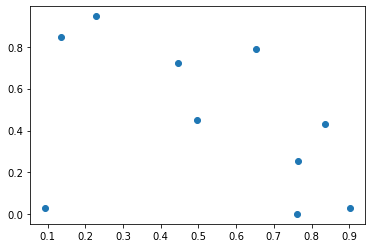

In [377]:
import matplotlib.pyplot as plt
xCoord = list()
yCoord = list()
for i in range(0, len(datasetMeans)):
    xCoord.append(datasetMeans[i][0])
    yCoord.append(datasetMeans[i][1])
plt.plot(xCoord, yCoord, 'o')
plt.show()